
# Taller de Ciencia de Datos: ETL + EDA Estadístico  
## Caso: Ecuador, Colombia y Perú (PIB, Población, Esperanza de Vida)

**Objetivo del Notebook:**  
Guiar paso a paso el proceso completo de:

1. **ETL (Extract – Transform – Load)** de un conjunto de datos simplificado para Ecuador, Colombia y Perú.
2. **EDA (Exploratory Data Analysis) con enfoque estadístico**, usando medidas de tendencia, dispersión, correlaciones y visualizaciones.

Este Notebook está diseñado para estudiantes que **ya manejan Python básico** y están empezando en Ciencia de Datos.



## 📚 Contenidos

1. **Configuración inicial** (importación de librerías)
2. **Construcción / Extracción de datos crudos (simulación de repositorio)**
3. **ETL**
   - Extract: obtención de los datos
   - Transform: limpieza, normalización y creación de nuevas variables
   - Load: almacenamiento en un CSV limpio
4. **EDA Descriptivo**
   - Dimensiones, tipos de datos
   - Medidas de tendencia central y dispersión
   - Histogramas y boxplots
5. **EDA Estadístico**
   - Agrupaciones (por país y año)
   - Correlaciones y matriz de correlación
   - Análisis de series de tiempo
   - Gráficos de dispersión entre variables (PIB, población, esperanza de vida)
6. **EDA Inferencial (Introductorio)**
   - Prueba de normalidad (Shapiro-Wilk)
   - Correlación de Pearson
7. **Ejercicios propuestos para el estudiante**



## 1️⃣ Configuración inicial

En esta sección importamos las librerías necesarias.

- `pandas`: manejo de datos tabulares.
- `numpy`: operaciones numéricas.
- `matplotlib` y `seaborn`: visualización.
- `scipy.stats`: algunas pruebas estadísticas básicas.


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import shapiro, pearsonr

# Configuración estética de gráficos
plt.style.use("default")
sns.set()



## 2️⃣ Construcción / Extracción de datos crudos

En un caso real, estos datos vendrían de un **repositorio de datos** (por ejemplo, Banco Mundial, Kaggle, datahub.io, etc.).  
Para hacer el taller **reproducible sin conexión**, simularemos que ya descargamos los datos y los construiremos directamente en el Notebook.

Las variables serán:

- `Pais`: Ecuador, Colombia, Perú  
- `Anio`: de 2010 a 2020  
- `PIB_per_capita`: PIB per cápita aproximado (USD corrientes, valores ficticios pero verosímiles)  
- `Poblacion`: población total aproximada  
- `Esperanza_vida`: años de esperanza de vida al nacer (ficticios pero razonables)


In [2]:

# Creamos listas de años y países
anios = list(range(2010, 2021))
paises = ["Ecuador", "Colombia", "Peru"]

# Generamos datos ficticios pero verosímiles
data = []

np.random.seed(42)  # Para reproducibilidad

for pais in paises:
    # Valores base aproximados para cada país
    if pais == "Ecuador":
        pib_base = 4000
        pob_base = 14500000
        vida_base = 74
    elif pais == "Colombia":
        pib_base = 5500
        pob_base = 46000000
        vida_base = 73
    else:  # Peru
        pib_base = 5000
        pob_base = 29000000
        vida_base = 72

    pib = pib_base
    pob = pob_base
    vida = vida_base

    for anio in anios:
        # Simulamos variaciones suaves año a año
        pib = pib * (1 + np.random.normal(0.03, 0.01))    # crecimiento ~3% con ruido
        pob = pob * (1 + np.random.normal(0.012, 0.003))  # crecimiento ~1.2%
        vida = vida + np.random.normal(0.05, 0.03)        # aumento lento

        data.append({
            "Pais": pais,
            "Anio": anio,
            "PIB_per_capita": round(pib, 2),
            "Poblacion": int(pob),
            "Esperanza_vida": round(vida, 2)
        })

# Creamos el DataFrame crudo
df_raw = pd.DataFrame(data)
df_raw.head()


,Pais,Anio,PIB_per_capita,Poblacion,Esperanza_vida
0,Ecuador,2010,4139.87,14667985,74.07
1,Ecuador,2011,4327.12,14833697,74.11
2,Ecuador,2012,4525.26,15045853,74.15
3,Ecuador,2013,4685.57,15205486,74.18
4,Ecuador,2014,4837.48,15300675,74.18



## 3️⃣ Proceso ETL (Extract – Transform – Load)

En este caso:

- **Extract:** ya lo realizamos simulando los datos (en la vida real sería leer un CSV, una API, una base de datos, etc.).  
- **Transform:** vamos a limpiar, verificar tipos, generar nuevas variables.  
- **Load:** guardaremos un archivo `datos_paises_limpio.csv` con los datos transformados.



### 3.1 Transform: inspección y limpieza


In [3]:

# Copiamos el DataFrame crudo para no modificar el original
df = df_raw.copy()

# Vistazo general
print("Dimensiones:", df.shape)
print("\nInformación general:")
print(df.info())

print("\nValores nulos por columna:")
print(df.isnull().sum())

df.head()


Dimensiones: (33, 5)

Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Pais            33 non-null     object 
 1   Anio            33 non-null     int64  
 2   PIB_per_capita  33 non-null     float64
 3   Poblacion       33 non-null     int64  
 4   Esperanza_vida  33 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 1.4+ KB
None

Valores nulos por columna:
Pais              0
Anio              0
PIB_per_capita    0
Poblacion         0
Esperanza_vida    0
dtype: int64


,Pais,Anio,PIB_per_capita,Poblacion,Esperanza_vida
0,Ecuador,2010,4139.87,14667985,74.07
1,Ecuador,2011,4327.12,14833697,74.11
2,Ecuador,2012,4525.26,15045853,74.15
3,Ecuador,2013,4685.57,15205486,74.18
4,Ecuador,2014,4837.48,15300675,74.18



En este punto podríamos:

- Eliminar filas con datos nulos.
- Corregir tipos de datos (si fuera necesario).
- Renombrar columnas para darles un nombre más amigable.


In [4]:

# Aseguramos tipos de datos correctos
df["Anio"] = df["Anio"].astype(int)
df["PIB_per_capita"] = df["PIB_per_capita"].astype(float)
df["Poblacion"] = df["Poblacion"].astype(int)
df["Esperanza_vida"] = df["Esperanza_vida"].astype(float)

# Creamos columna de año en formato datetime (opcional para series de tiempo)
df["Fecha"] = pd.to_datetime(df["Anio"], format="%Y")

df.head()


,Pais,Anio,PIB_per_capita,Poblacion,Esperanza_vida,Fecha
0,Ecuador,2010,4139.87,14667985,74.07,2010-01-01
1,Ecuador,2011,4327.12,14833697,74.11,2011-01-01
2,Ecuador,2012,4525.26,15045853,74.15,2012-01-01
3,Ecuador,2013,4685.57,15205486,74.18,2013-01-01
4,Ecuador,2014,4837.48,15300675,74.18,2014-01-01



### 3.2 Creación de nuevas variables

Creamos, por ejemplo:

- `PIB_total` = PIB per cápita × población  
- `Crecimiento_PIB_per_capita` = % de cambio anual del PIB per cápita por país  
- `Crecimiento_Poblacion` = % de cambio anual de la población por país


In [5]:

# PIB total (millones de USD aproximadamente)
df["PIB_total"] = df["PIB_per_capita"] * df["Poblacion"]

# Ordenamos por país y año antes de calcular tasas
df = df.sort_values(by=["Pais", "Anio"])

# Tasas de crecimiento porcentual
df["Crecimiento_PIB_per_capita"] = df.groupby("Pais")["PIB_per_capita"].pct_change() * 100
df["Crecimiento_Poblacion"] = df.groupby("Pais")["Poblacion"].pct_change() * 100

df.head(10)


,Pais,Anio,PIB_per_capita,Poblacion,Esperanza_vida,Fecha,PIB_total,Crecimiento_PIB_per_capita,Crecimiento_Poblacion
11,Colombia,2010,5606.83,46665511,73.01,2010-01-01,2.616456e+11,NaN,NaN
12,Colombia,2011,5786.74,46951150,73.02,2011-01-01,2.716941e+11,3.208765,0.612099
13,Colombia,2012,5971.74,47618579,73.08,2012-01-01,2.843658e+11,3.196964,1.421539
14,Colombia,2013,6143.98,48146988,73.08,2013-01-01,2.958141e+11,2.884251,1.109670
15,Colombia,2014,6284.07,48658216,73.17,2014-01-01,3.057716e+11,2.280118,1.061807
16,Colombia,2015,6494.19,48984756,73.23,2015-01-01,3.181163e+11,3.343693,0.671089
17,Colombia,2016,6664.01,49473096,73.29,2016-01-01,3.296892e+11,2.614953,0.996922
18,Colombia,2017,6932.63,50204994,73.32,2017-01-01,3.480526e+11,4.030906,1.479386
19,Colombia,2018,7119.18,50857347,73.40,2018-01-01,3.620626e+11,2.690898,1.299379
20,Colombia,2019,7298.64,51439308,73.42,2019-01-01,3.754370e+11,2.520796,1.144301



### 3.3 Load: guardado de datos limpios

Guardamos el DataFrame resultante en un archivo CSV para usos posteriores.


In [6]:

df.to_csv("datos_paises_limpio.csv", index=False)
print("Archivo 'datos_paises_limpio.csv' guardado correctamente.")


Archivo 'datos_paises_limpio.csv' guardado correctamente.



## 4️⃣ EDA Descriptivo

En esta sección haremos un análisis exploratorio básico:

- Dimensiones y estructura
- Estadísticos descriptivos (media, mediana, desviación estándar)
- Distribuciones (histogramas)
- Boxplots para observar dispersión y outliers


In [7]:

# Cargamos el archivo limpio (simulando que venimos "desde cero")
df_eda = pd.read_csv("datos_paises_limpio.csv")

print("Dimensiones:", df_eda.shape)
df_eda.head()


Dimensiones: (33, 9)


,Pais,Anio,PIB_per_capita,Poblacion,Esperanza_vida,Fecha,PIB_total,Crecimiento_PIB_per_capita,Crecimiento_Poblacion
0,Colombia,2010,5606.83,46665511,73.01,2010-01-01,2.616456e+11,NaN,NaN
1,Colombia,2011,5786.74,46951150,73.02,2011-01-01,2.716941e+11,3.208765,0.612099
2,Colombia,2012,5971.74,47618579,73.08,2012-01-01,2.843658e+11,3.196964,1.421539
3,Colombia,2013,6143.98,48146988,73.08,2013-01-01,2.958141e+11,2.884251,1.109670
4,Colombia,2014,6284.07,48658216,73.17,2014-01-01,3.057716e+11,2.280118,1.061807


In [8]:

# Estadísticos descriptivos generales
df_eda[["PIB_per_capita", "Poblacion", "Esperanza_vida", "PIB_total"]].describe()


,PIB_per_capita,Poblacion,Esperanza_vida,PIB_total
count,33.000000,3.300000e+01,33.000000,3.300000e+01
mean,5813.365152,3.201125e+07,73.253636,1.956372e+11
std,869.481581,1.404640e+07,0.834194,1.057577e+11
min,4139.870000,1.466798e+07,72.060000,6.072355e+10
25%,5199.420000,1.594169e+07,72.420000,8.492298e+10
50%,5786.740000,3.138268e+07,73.230000,1.882961e+11
75%,6494.190000,4.761858e+07,74.150000,2.843658e+11
max,7430.290000,5.218197e+07,74.450000,3.877271e+11



### 4.1 Histogramas: distribución de variables numéricas


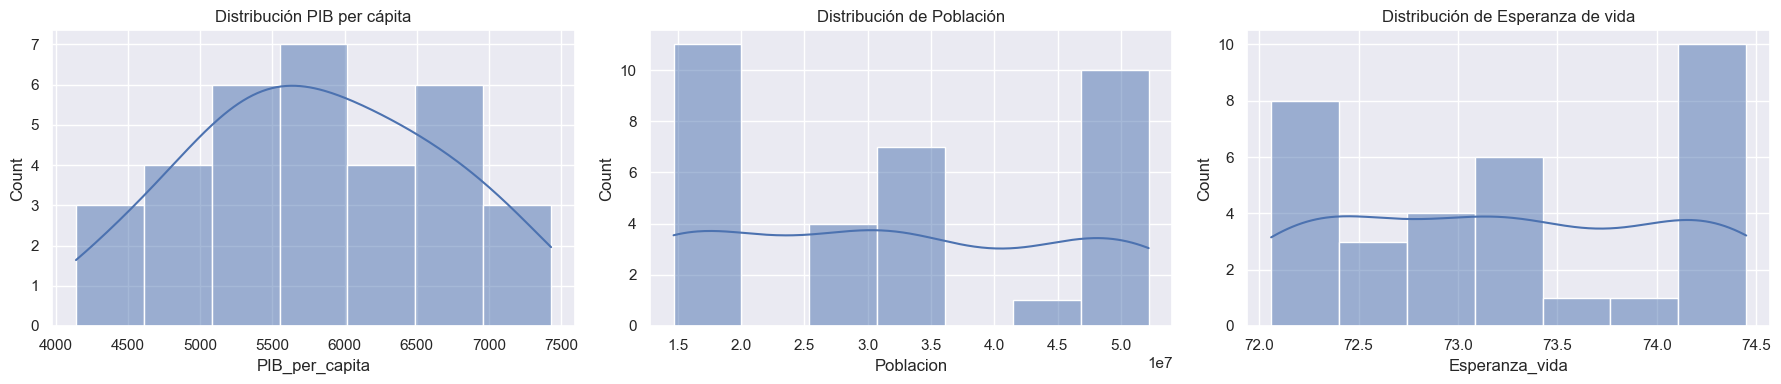

In [9]:

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

sns.histplot(df_eda["PIB_per_capita"], kde=True, ax=axes[0])
axes[0].set_title("Distribución PIB per cápita")

sns.histplot(df_eda["Poblacion"], kde=True, ax=axes[1])
axes[1].set_title("Distribución de Población")

sns.histplot(df_eda["Esperanza_vida"], kde=True, ax=axes[2])
axes[2].set_title("Distribución de Esperanza de vida")

plt.tight_layout()
plt.show()



### 4.2 Boxplots: detección visual de outliers


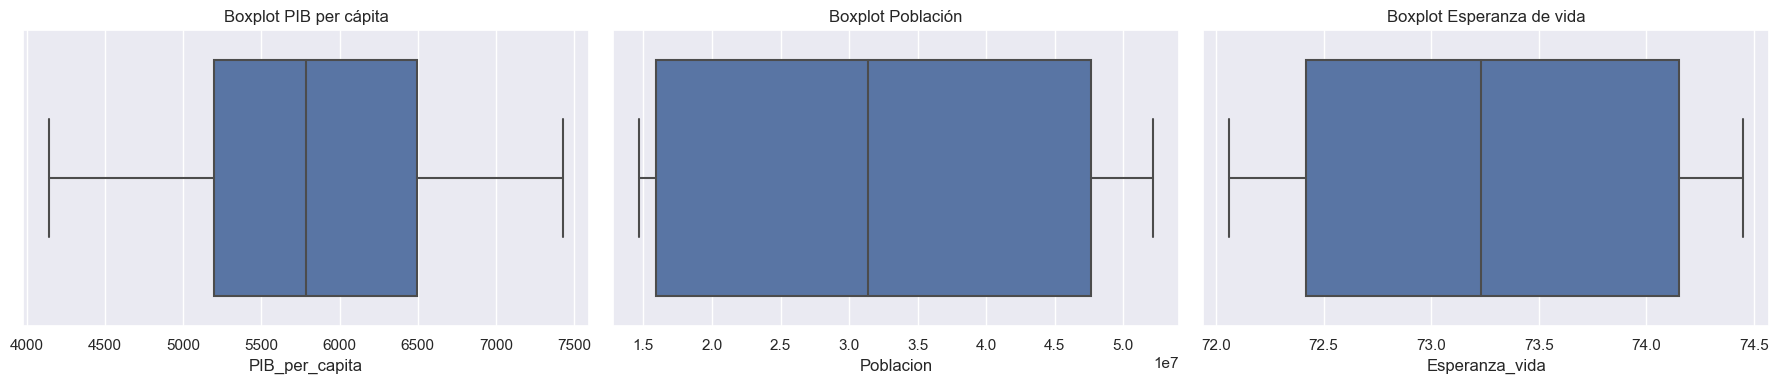

In [10]:

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

sns.boxplot(x=df_eda["PIB_per_capita"], ax=axes[0])
axes[0].set_title("Boxplot PIB per cápita")

sns.boxplot(x=df_eda["Poblacion"], ax=axes[1])
axes[1].set_title("Boxplot Población")

sns.boxplot(x=df_eda["Esperanza_vida"], ax=axes[2])
axes[2].set_title("Boxplot Esperanza de vida")

plt.tight_layout()
plt.show()



## 5️⃣ EDA Estadístico

Ahora profundizamos en el análisis:

- Estadísticos por país
- Comparaciones entre países
- Matriz de correlación
- Análisis de series de tiempo (evolución por año)
- Relación entre desarrollo (PIB, esperanza de vida) y población



### 5.1 Estadísticos por país


In [11]:

# Media de cada variable por país
estadisticos_pais = df_eda.groupby("Pais")[["PIB_per_capita", "Poblacion", "Esperanza_vida"]].agg(
    ["mean", "std", "min", "max"]
)
estadisticos_pais


PIB_per_capita                                   Poblacion  \
                   mean         std      min      max          mean   
Pais                                                                  
Colombia    6521.118182  620.868127  5606.83  7430.29  4.919836e+07   
Ecuador     4927.472727  479.885734  4139.87  5638.99  1.547542e+07   
Peru        5991.504545  595.170591  5146.40  6927.42  3.135998e+07   

                                           Esperanza_vida                   \
                   std       min       max           mean       std    min   
Pais                                                                         
Colombia  1.821223e+06  46665511  52181967      73.230000  0.172105  73.01   
Ecuador   5.364439e+05  14667985  16387005      74.256364  0.127379  74.07   
Peru      1.256850e+06  29435307  33291986      72.274545  0.140951  72.06   

                 
            max  
Pais             
Colombia  73.51  
Ecuador   74.45  
Peru      72.48


### 5.2 Comparación gráfica de PIB per cápita promedio por país


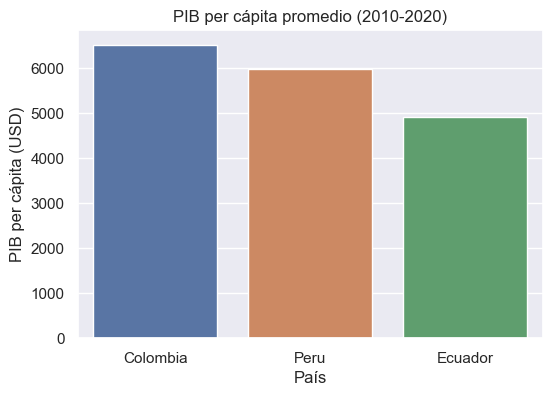

In [12]:

pib_promedio = df_eda.groupby("Pais")["PIB_per_capita"].mean().sort_values(ascending=False)

plt.figure(figsize=(6,4))
sns.barplot(x=pib_promedio.index, y=pib_promedio.values)
plt.title("PIB per cápita promedio (2010-2020)")
plt.ylabel("PIB per cápita (USD)")
plt.xlabel("País")
plt.show()



### 5.3 Matriz de correlación

Analizamos la correlación entre:

- PIB per cápita  
- Población  
- Esperanza de vida  
- PIB total


In [13]:

corr = df_eda[["PIB_per_capita", "Poblacion", "Esperanza_vida", "PIB_total"]].corr()
corr


,PIB_per_capita,Poblacion,Esperanza_vida,PIB_total
PIB_per_capita,1.000000,0.805888,-0.404712,0.882861
Poblacion,0.805888,1.000000,-0.464940,0.983274
Esperanza_vida,-0.404712,-0.464940,1.000000,-0.407179
PIB_total,0.882861,0.983274,-0.407179,1.000000


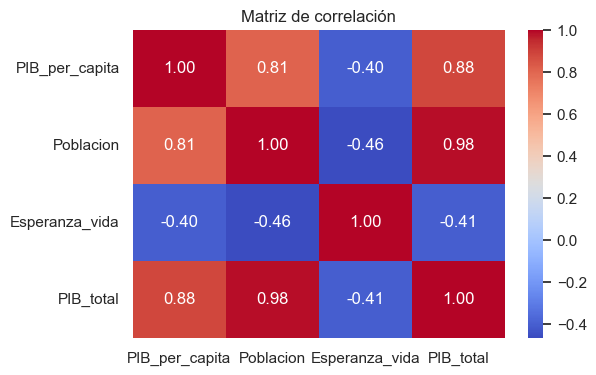

In [14]:

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de correlación")
plt.show()



### 5.4 Series de tiempo: evolución del PIB per cápita

Graficamos cómo ha cambiado el PIB per cápita en el tiempo para cada país.


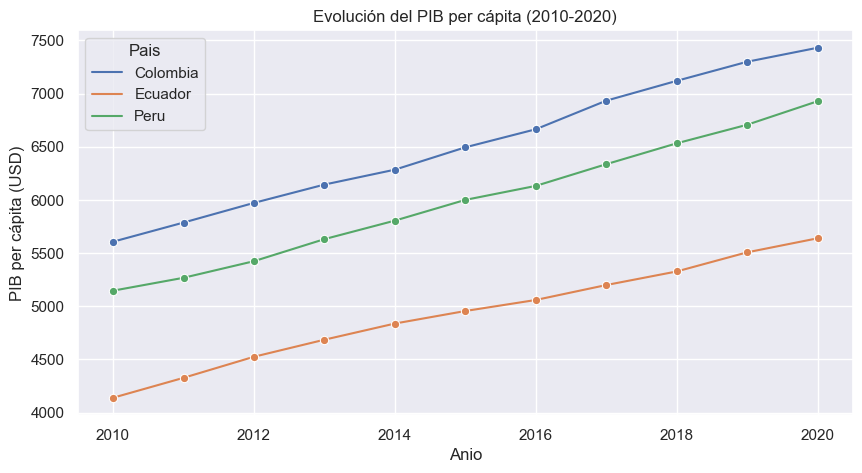

In [15]:

plt.figure(figsize=(10,5))
sns.lineplot(data=df_eda, x="Anio", y="PIB_per_capita", hue="Pais", marker="o")
plt.title("Evolución del PIB per cápita (2010-2020)")
plt.ylabel("PIB per cápita (USD)")
plt.show()



### 5.5 Relación entre PIB per cápita y esperanza de vida


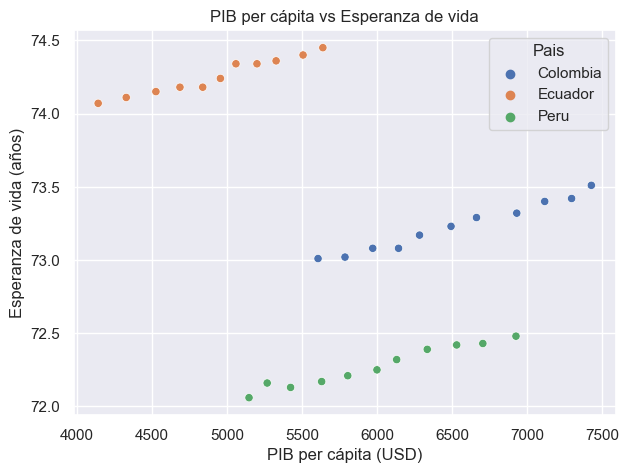

In [16]:

plt.figure(figsize=(7,5))
sns.scatterplot(data=df_eda, x="PIB_per_capita", y="Esperanza_vida", hue="Pais")
plt.title("PIB per cápita vs Esperanza de vida")
plt.xlabel("PIB per cápita (USD)")
plt.ylabel("Esperanza de vida (años)")
plt.show()



## 6️⃣ EDA Inferencial (Introductorio)

En esta sección introducimos algunas ideas básicas de estadística inferencial:

- **Prueba de normalidad (Shapiro-Wilk)** sobre el PIB per cápita.
- **Correlación de Pearson** entre PIB per cápita y esperanza de vida.



### 6.1 Prueba de normalidad (Shapiro-Wilk) para PIB per cápita

> **Hipótesis nula (H0):** los datos provienen de una distribución normal.  
> Si el p-valor < 0.05, rechazamos H0 (no son normales).


In [17]:

# Tomamos una muestra (por si el N fuera muy grande)
muestra_pib = df_eda["PIB_per_capita"].sample(min(100, len(df_eda)), random_state=42)

stat, p_value = shapiro(muestra_pib)
print(f"Estadístico Shapiro-Wilk: {stat:.4f}")
print(f"p-valor: {p_value:.4f}")


Estadístico Shapiro-Wilk: 0.9842
p-valor: 0.8998



### 6.2 Correlación de Pearson entre PIB per cápita y Esperanza de vida

> **Hipótesis nula:** no hay correlación lineal entre las variables.  
> Si el p-valor < 0.05, hay evidencia de correlación lineal significativa.


In [18]:

corr_pearson, p_val = pearsonr(df_eda["PIB_per_capita"], df_eda["Esperanza_vida"])
print(f"Correlación de Pearson: {corr_pearson:.4f}")
print(f"p-valor: {p_val:.4f}")


Correlación de Pearson: -0.4047
p-valor: 0.0195



## 7️⃣ Ejercicios propuestos para el estudiante

1. **Medidas descriptivas por país**
   - Calcula la media, mediana y desviación estándar de la esperanza de vida para cada país.
   - Interpreta: ¿Qué país muestra mayor estabilidad (menor desviación)?

2. **Análisis de crecimiento**
   - Utiliza las columnas `Crecimiento_PIB_per_capita` y `Crecimiento_Poblacion`.
   - Calcula el crecimiento promedio del PIB per cápita entre 2010 y 2020 por país.
   - ¿Qué país ha crecido más rápido según estos datos simulados?

3. **Boxplots por país**
   - Crea un boxplot de `PIB_per_capita` por país (en el eje X el país, en el Y el PIB per cápita).
   - ¿Qué diferencias encuentras en la dispersión?

4. **Profundiza en la correlación**
   - Calcula la correlación entre `Poblacion` y `PIB_total`.
   - Interpreta el resultado: ¿es esperable ese signo y magnitud? ¿por qué?

5. **Extensión opcional (para investigar en casa)**
   - Reemplaza estos datos simulados con un dataset real descargado del **Banco Mundial** o **datahub.io**.
   - Repite el EDA y compara resultados.
